# Evaluating your SAE

Code based off Rob Graham's ([themachinefan](https://github.com/themachinefan)) SAE evaluation code.

In [1]:
import os
os.getcwd()

'/workspace/ViT-Prisma/src/vit_prisma/sae/evals'

In [2]:
import einops
import torch
import torchvision

import plotly.express as px

from tqdm import tqdm

import numpy as np
import os
import requests

# Setup

In [3]:
from dataclasses import dataclass
from vit_prisma.sae.config import VisionModelSAERunnerConfig


@dataclass
class EvalConfig(VisionModelSAERunnerConfig):
    sae_path: str = '/workspace/sae_checkpoints/sparse-autoencoder-clip-b-32-sae-vanilla-x64-layer-11-hook_resid_post-l1-0.0001/n_images_2600058.pt'
    model_name: str = "open-clip:laion/CLIP-ViT-B-32-DataComp.XL-s13B-b90K"
    model_type: str =  "clip"
    patch_size: str = 32

    dataset_path = "/workspace"
    dataset_train_path: str = "/workspace/ILSVRC/Data/CLS-LOC/train"
    dataset_val_path: str = "/workspace/ILSVRC/Data/CLS-LOC/val"

    verbose: bool = True

    device: bool = 'cuda'

    eval_max: int = 50_000 # 50_000
    batch_size: int = 32

    # make the max image output folder a subfolder of the sae path


    @property
    def max_image_output_folder(self) -> str:
        # Get the base directory of sae_checkpoints
        sae_base_dir = os.path.dirname(os.path.dirname(self.sae_path))
        
        # Get the name of the original SAE checkpoint folder
        sae_folder_name = os.path.basename(os.path.dirname(self.sae_path))
        
        # Create a new folder path in sae_checkpoints/images with the original name
        output_folder = os.path.join(sae_base_dir, 'max_images', sae_folder_name)
        output_folder = os.path.join(output_folder, f"layer_{self.hook_point_layer}") # Add layer number

        
        # Ensure the directory exists
        os.makedirs(output_folder, exist_ok=True)
        
        return output_folder

cfg = EvalConfig()

n_tokens_per_buffer (millions): 0.032
Lower bound: n_contexts_per_buffer (millions): 0.00064
Total training steps: 158691
Total training images: 13000000
Total wandb updates: 15869
Expansion factor: 16
n_tokens_per_feature_sampling_window (millions): 204.8
n_tokens_per_dead_feature_window (millions): 1024.0
Using Ghost Grads.
We will reset the sparsity calculation 158 times.
Number tokens in sparsity calculation window: 4.10e+06
Gradient clipping with max_norm=1.0
Using SAE initialization method: encoder_transpose_decoder


In [4]:
torch.set_grad_enabled(False)

## Load model

In [5]:
from vit_prisma.models.base_vit import HookedViT

model_name = "open-clip:laion/CLIP-ViT-B-32-DataComp.XL-s13B-b90K"
model = HookedViT.from_pretrained(model_name, is_timm=False, is_clip=True).to(cfg.device)
 

model_id download_pretrained_from_hf: laion/CLIP-ViT-B-32-DataComp.XL-s13B-b90K
Official model name open-clip:laion/CLIP-ViT-B-32-DataComp.XL-s13B-b90K
Converting OpenCLIP weights
model_id download_pretrained_from_hf: laion/CLIP-ViT-B-32-DataComp.XL-s13B-b90K
visual projection shape torch.Size([768, 512])
Setting center_writing_weights to False for OpenCLIP
Setting fold_ln to False for OpenCLIP
Loaded pretrained model open-clip:laion/CLIP-ViT-B-32-DataComp.XL-s13B-b90K into HookedTransformer


## Load datasets

In [6]:
import importlib
import vit_prisma
# importlib.reload(vit_prisma.dataloaders.imagenet_dataset)

In [7]:
# load dataset
import open_clip
from vit_prisma.utils.data_utils.imagenet_utils import setup_imagenet_paths
from vit_prisma.dataloaders.imagenet_dataset import get_imagenet_transforms_clip, ImageNetValidationDataset

from torchvision import transforms
from transformers import CLIPProcessor

og_model_name = "hf-hub:laion/CLIP-ViT-B-32-DataComp.XL-s13B-b90K"
og_model, _, preproc = open_clip.create_model_and_transforms(og_model_name)
processor = preproc

size=224

data_transforms = transforms.Compose([
    transforms.Resize((size, size)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.48145466, 0.4578275, 0.40821073],
                     std=[0.26862954, 0.26130258, 0.27577711]),
])
    
imagenet_paths = setup_imagenet_paths(cfg.dataset_path)
imagenet_paths["train"] = "/workspace/ILSVRC/Data/CLS-LOC/train"
imagenet_paths["val"] = "/workspace/ILSVRC/Data/CLS-LOC/val"
imagenet_paths["val_labels"] = "/workspace/LOC_val_solution.csv"
imagenet_paths["label_strings"] = "/workspace/LOC_synset_mapping.txt"
print()
train_data = torchvision.datasets.ImageFolder(cfg.dataset_train_path, transform=data_transforms)
val_data = ImageNetValidationDataset(cfg.dataset_val_path, 
                                imagenet_paths['label_strings'], 
                                imagenet_paths['val_labels'], 
                                data_transforms,
                                return_index=True,
)
val_data_visualize = ImageNetValidationDataset(cfg.dataset_val_path, 
                                imagenet_paths['label_strings'], 
                                imagenet_paths['val_labels'],
                                torchvision.transforms.Compose([
    torchvision.transforms.Resize((224, 224)),
    torchvision.transforms.ToTensor(),]), return_index=True)

print(f"Validation data length: {len(val_data)}") if cfg.verbose else None



Validation data length: 50000


In [8]:
from vit_prisma.sae.training.activations_store import VisionActivationsStore
# import dataloader
from torch.utils.data import DataLoader

# activations_loader = VisionActivationsStore(cfg, model, train_data, eval_dataset=val_data)
val_dataloader = DataLoader(val_data, batch_size=cfg.batch_size, shuffle=False, num_workers=4)


## Load pretrained SAE to evaluate

In [9]:
from vit_prisma.sae.sae import SparseAutoencoder
sparse_autoencoder = SparseAutoencoder(cfg).load_from_pretrained("/workspace/sae_checkpoints/sparse-autoencoder-clip-b-32-sae-vanilla-x64-layer-11-hook_resid_post-l1-0.0001/n_images_2600058.pt")
sparse_autoencoder.to(cfg.device)
sparse_autoencoder.eval()  # prevents error if we're expecting a dead neuron mask for who 


get_activation_fn received: activation_fn=relu, kwargs={}
n_tokens_per_buffer (millions): 0.032
Lower bound: n_contexts_per_buffer (millions): 0.00064
Total training steps: 158691
Total training images: 13000000
Total wandb updates: 1586
Expansion factor: 64
n_tokens_per_feature_sampling_window (millions): 204.8
n_tokens_per_dead_feature_window (millions): 1024.0
Using Ghost Grads.
We will reset the sparsity calculation 158 times.
Number tokens in sparsity calculation window: 4.10e+06
Gradient clipping with max_norm=1.0
Using SAE initialization method: encoder_transpose_decoder
get_activation_fn received: activation_fn=relu, kwargs={}


SparseAutoencoder(
  (hook_sae_in): HookPoint()
  (hook_hidden_pre): HookPoint()
  (hook_hidden_post): HookPoint()
  (hook_sae_out): HookPoint()
  (activation_fn): ReLU()
)

## Clip Labeling AutoInterp

In [10]:
# all_imagenet_class_names

In [11]:
from vit_prisma.dataloaders.imagenet_dataset import get_imagenet_index_to_name
ind_to_name = get_imagenet_index_to_name()

all_imagenet_class_names = []
for i in range(len(ind_to_name)):
    all_imagenet_class_names.append(ind_to_name[str(i)][1])

In [12]:
cfg.max_image_output_folder

'/workspace/sae_checkpoints/max_images/sparse-autoencoder-clip-b-32-sae-vanilla-x64-layer-11-hook_resid_post-l1-0.0001/layer_9'

## Feature steering

In [35]:
def steering_hook_fn(
    activations, cfg, hook, sae, steering_indices, steering_strength=1.0, mean_ablation_values=None, include_error=False

):
    sae.to(activations.device)


    sae_input = activations.clone()
    sae_output, feature_activations, *data = sae(sae_input)
    
    steered_feature_activations = feature_activations.clone()
    
    steered_feature_activations[:, :, steering_indices] = steering_strength

    steered_sae_out = einops.einsum(
                steered_feature_activations,
                sae.W_dec,
                "... d_sae, d_sae d_in -> ... d_in",
            ) + sae.b_dec

    steered_sae_out = sae.run_time_activation_norm_fn_out(steered_sae_out)
    
    print(steered_sae_out.shape)
    print(steered_sae_out.shape)
    print(f"steering norm: {(steered_sae_out - sae_output).norm()}")
    
    

    if include_error:
        error = sae_input - sae_output
        print(f"error.norm(): {error.norm()}")
        return steered_sae_out + error
    return steered_sae_out

In [36]:
random_feat_idxs = np.random.randint(0, high=3000, size=(25))

In [252]:
# for a given feature, set it high/low on maxim activ. imgs and high/low on non-activ images
# hook SAE and replace desired feature with 0 or 1 
from typing import List, Dict, Tuple
import torch
import einops
from tqdm import tqdm

from functools import partial

@torch.no_grad()
def compute_feature_activations_set_feat(
    images: torch.Tensor,
    model: torch.nn.Module,
    sparse_autoencoder: torch.nn.Module,
    encoder_weights: torch.Tensor,
    encoder_biases: torch.Tensor,
    feature_ids: List[int],
    feature_categories: List[str],
    top_k: int = 10,
    steering_strength: float = 10.0
):
    """
    Compute the highest activating tokens for given features in a batch of images.
    
    Args:
        images: Input images
        model: The main model
        sparse_autoencoder: The sparse autoencoder
        encoder_weights: Encoder weights for selected features
        encoder_biases: Encoder biases for selected features
        feature_ids: List of feature IDs to analyze
        feature_categories: Categories of the features
        top_k: Number of top activations to return per feature

    Returns:
        Dictionary mapping feature IDs to tuples of (top_indices, top_values)
    """
#     _, cache = model.run_with_cache(images, names_filter=[sparse_autoencoder.cfg.hook_point])
    recons_image_embeddings_feat_altered_list = []
    for idx in np.array(range(sparse_autoencoder.W_dec.shape[0]))[random_feat_idxs]:
        print(f"Feature: {idx} ====================")
        
        steering_hook = partial(
            steering_hook_fn,
            cfg=cfg,
            sae=sparse_autoencoder,
            steering_indices=[idx],
            steering_strength=steering_strength,
            mean_ablation_values = [1.0],
            include_error=True,
            )
        
        
        recons_image_embeddings_feat_altered = model.run_with_hooks(
            images,
            fwd_hooks=[("blocks.9.hook_mlp_out", steering_hook)],
        )
        recons_image_embeddings_feat_altered_list.append(recons_image_embeddings_feat_altered)

    
    # output is in clip embedding space
    recons_image_embeddings_default = model.run_with_hooks(
        images,
        fwd_hooks=[("blocks.9.hook_mlp_out", lambda x, hook: x)],
    )
    
    print(f"recons_image_embeddings_default: {recons_image_embeddings_default}")
    print(f"recons_image_embeddings_default.shape: {recons_image_embeddings_default.shape}")
    print(f"recons_image_embeddings_default: {recons_image_embeddings_default.shape}")

    print(f"recons_image_embeddings_feat_altered: {recons_image_embeddings_feat_altered}")
    print(f"recons_image_embeddings_feat_altered.shape: {recons_image_embeddings_feat_altered.shape}")

    return recons_image_embeddings_feat_altered_list, recons_image_embeddings_default

In [390]:
from collections import defaultdict
max_samples = cfg.eval_max

# top_activations = {i: (None, None) for i in interesting_features_indices}
encoder_biases = sparse_autoencoder.b_enc#[interesting_features_indices]
encoder_weights = sparse_autoencoder.W_enc#[:, interesting_features_indices]

# positive = -1 * np.array([-50.0, -20.0, -10.0, -5.0, -2.5, -1.5, -1.0, -.75, -.5, -.25, -.1])
# steering_strengths = np.array([-50.0, -20.0, -10.0, -5.0, -2.5, -1.5, -1.0, -.75, -.5, -.25, -.1, 0])
# steering_strengths = np.concatenate((steering_strengths, positive))
# print(steering_strengths)
# strengths = defaultdict(list)
# for steering_strength in steering_strengths:
steering_strength = 150.0

top_k=10
processed_samples = 0
default_embeds_list = []
feature_steered_embeds = defaultdict(list)
l = 0
for batch_images, _, batch_indices in tqdm(val_dataloader, total=max_samples // cfg.batch_size):
    batch_images = batch_images.to(cfg.device)
    batch_indices = batch_indices.to(cfg.device)
    batch_size = batch_images.shape[0]

    altered_embeds_list, default_embeds = compute_feature_activations_set_feat(
        batch_images, model, sparse_autoencoder, encoder_weights, encoder_biases,
        None, None, top_k, steering_strength
    )
    default_embeds_list.append(default_embeds)
    for j, altered_embeds in enumerate(altered_embeds_list):
        feature_steered_embeds[random_feat_idxs[j]].extend(altered_embeds)
    # either label embeds or optimize to maximal token in text transformer embedding face
    l += 1
    if l >= 5:
        break    
        

  0%|                                                                                                            | 0/1562 [00:00<?, ?it/s]

Feature: 1159 ====================
torch.Size([32, 50, 768])
torch.Size([32, 50, 768])
steering norm: 6000.00048828125
error.norm(): 561.3306884765625
Feature: 1451 ====================
torch.Size([32, 50, 768])
torch.Size([32, 50, 768])
steering norm: 6000.0
error.norm(): 561.3306884765625
Feature: 1878 ====================
torch.Size([32, 50, 768])
torch.Size([32, 50, 768])
steering norm: 6000.00048828125
error.norm(): 561.3306884765625
Feature: 316 ====================
torch.Size([32, 50, 768])
torch.Size([32, 50, 768])
steering norm: 6000.0
error.norm(): 561.3306884765625
Feature: 313 ====================
torch.Size([32, 50, 768])
torch.Size([32, 50, 768])
steering norm: 6000.0
error.norm(): 561.3306884765625
Feature: 1359 ====================
torch.Size([32, 50, 768])
torch.Size([32, 50, 768])
steering norm: 6000.0
error.norm(): 561.3306884765625
Feature: 635 ====================
torch.Size([32, 50, 768])
torch.Size([32, 50, 768])
steering norm: 5999.99951171875
error.norm(): 561.

  0%|                                                                                                    | 1/1562 [00:01<48:30,  1.86s/it]

torch.Size([32, 50, 768])
torch.Size([32, 50, 768])
steering norm: 6000.00048828125
error.norm(): 561.3306884765625
Feature: 696 ====================
torch.Size([32, 50, 768])
torch.Size([32, 50, 768])
steering norm: 6000.0
error.norm(): 561.3306884765625
recons_image_embeddings_default: tensor([[ 0.0352,  0.0083, -0.0740,  ..., -0.0311,  0.0275,  0.0019],
        [-0.0101, -0.0539, -0.0622,  ...,  0.0199, -0.0555, -0.0743],
        [-0.0206,  0.0059, -0.0366,  ..., -0.0307,  0.0756, -0.0016],
        ...,
        [ 0.0099, -0.0045, -0.0059,  ..., -0.0521,  0.0647, -0.0225],
        [-0.0422,  0.0518, -0.0482,  ...,  0.0098,  0.0418,  0.0290],
        [-0.0411, -0.0590,  0.0014,  ..., -0.0432, -0.0089, -0.0449]],
       device='cuda:0')
recons_image_embeddings_default.shape: torch.Size([32, 512])
recons_image_embeddings_default: torch.Size([32, 512])
recons_image_embeddings_feat_altered: tensor([[ 0.0341, -0.0319, -0.0274,  ...,  0.0371,  0.0576, -0.0055],
        [ 0.0295, -0.0321, -0

  0%|▏                                                                                                   | 2/1562 [00:03<41:59,  1.61s/it]

recons_image_embeddings_default: tensor([[ 0.0146, -0.0148, -0.0460,  ...,  0.0118,  0.0082,  0.0083],
        [-0.0018,  0.0212, -0.0113,  ...,  0.0519, -0.0585, -0.0361],
        [-0.0171, -0.0393, -0.0432,  ...,  0.0160,  0.0028,  0.0136],
        ...,
        [-0.0224, -0.0082, -0.0361,  ..., -0.0352,  0.0784,  0.0265],
        [-0.0062,  0.0247, -0.0572,  ...,  0.0121, -0.0083,  0.0222],
        [-0.0130,  0.0321, -0.0363,  ...,  0.0437,  0.0279, -0.0109]],
       device='cuda:0')
recons_image_embeddings_default.shape: torch.Size([32, 512])
recons_image_embeddings_default: torch.Size([32, 512])
recons_image_embeddings_feat_altered: tensor([[ 0.0287, -0.0333, -0.0237,  ...,  0.0385,  0.0577, -0.0079],
        [ 0.0317, -0.0317, -0.0243,  ...,  0.0427,  0.0523, -0.0075],
        [ 0.0327, -0.0313, -0.0280,  ...,  0.0390,  0.0565, -0.0087],
        ...,
        [ 0.0319, -0.0320, -0.0248,  ...,  0.0389,  0.0563, -0.0038],
        [ 0.0312, -0.0324, -0.0245,  ...,  0.0388,  0.0559, -0

  0%|▏                                                                                                   | 3/1562 [00:04<39:57,  1.54s/it]

torch.Size([32, 50, 768])
torch.Size([32, 50, 768])
steering norm: 6000.00048828125
error.norm(): 559.0997314453125
Feature: 696 ====================
torch.Size([32, 50, 768])
torch.Size([32, 50, 768])
steering norm: 6000.0
error.norm(): 559.0997314453125
recons_image_embeddings_default: tensor([[ 0.0294,  0.0383,  0.0048,  ..., -0.0036,  0.0256,  0.0279],
        [ 0.0004,  0.0353, -0.0868,  ..., -0.0146,  0.0002,  0.0059],
        [ 0.0709, -0.0185, -0.0175,  ...,  0.0050,  0.0293,  0.0257],
        ...,
        [-0.0168, -0.0003, -0.0274,  ..., -0.0302,  0.0601, -0.0477],
        [ 0.0075,  0.0213, -0.0235,  ..., -0.0346,  0.0216,  0.0487],
        [ 0.0059, -0.0119, -0.0019,  ...,  0.0249, -0.0424,  0.0157]],
       device='cuda:0')
recons_image_embeddings_default.shape: torch.Size([32, 512])
recons_image_embeddings_default: torch.Size([32, 512])
recons_image_embeddings_feat_altered: tensor([[ 0.0309, -0.0311, -0.0237,  ...,  0.0403,  0.0569, -0.0061],
        [ 0.0325, -0.0306, -0

  0%|▎                                                                                                   | 4/1562 [00:06<39:03,  1.50s/it]

recons_image_embeddings_default: tensor([[ 0.0495,  0.0061, -0.0375,  ..., -0.0073, -0.0049,  0.0464],
        [ 0.0656,  0.0185, -0.0169,  ..., -0.0542,  0.0806,  0.0280],
        [ 0.0439,  0.0136,  0.0194,  ..., -0.0279,  0.0640, -0.0370],
        ...,
        [ 0.0259,  0.0402, -0.0065,  ..., -0.0289,  0.0129,  0.0450],
        [ 0.0245,  0.0248, -0.0074,  ..., -0.0344,  0.0273, -0.0038],
        [ 0.0167,  0.0346, -0.0975,  ...,  0.0074,  0.0849, -0.0346]],
       device='cuda:0')
recons_image_embeddings_default.shape: torch.Size([32, 512])
recons_image_embeddings_default: torch.Size([32, 512])
recons_image_embeddings_feat_altered: tensor([[ 0.0344, -0.0303, -0.0264,  ...,  0.0367,  0.0553, -0.0050],
        [ 0.0326, -0.0307, -0.0253,  ...,  0.0359,  0.0585, -0.0066],
        [ 0.0306, -0.0328, -0.0233,  ...,  0.0398,  0.0623, -0.0072],
        ...,
        [ 0.0313, -0.0296, -0.0232,  ...,  0.0374,  0.0557, -0.0046],
        [ 0.0333, -0.0295, -0.0278,  ...,  0.0384,  0.0572, -0

  0%|▎                                                                                                   | 4/1562 [00:07<50:31,  1.95s/it]


In [391]:
len(feature_steered_embeds[random_feat_idxs[0]])

160

In [392]:
default_embeds.shape
len(default_embeds_list)
default_embeds = torch.cat(default_embeds_list)
default_embeds.shape

torch.Size([160, 512])

In [393]:

len(altered_embeds_list), altered_embeds_list[0].shape, default_embeds.shape

(25, torch.Size([32, 512]), torch.Size([160, 512]))

In [394]:
og_model.cuda()

CLIP(
  (visual): VisionTransformer(
    (conv1): Conv2d(3, 768, kernel_size=(32, 32), stride=(32, 32), bias=False)
    (patch_dropout): Identity()
    (ln_pre): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
    (transformer): Transformer(
      (resblocks): ModuleList(
        (0-11): 12 x ResidualAttentionBlock(
          (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
          (attn): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
          )
          (ls_1): Identity()
          (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
          (mlp): Sequential(
            (c_fc): Linear(in_features=768, out_features=3072, bias=True)
            (gelu): GELU(approximate='none')
            (c_proj): Linear(in_features=3072, out_features=768, bias=True)
          )
          (ls_2): Identity()
        )
      )
    )
    (ln_post): LayerNorm((768,), eps=1e-05, elementwise_affine

In [395]:
with open("/workspace/clip_dissect_raw.txt", "r") as f:
    larger_vocab = [line[:-1] for line in f.readlines()][:5000]

# with open("/workspace/better_img_desc.txt", "r") as f:
#     larger_vocab = [line[:-1] for line in f.readlines()][:5000]

In [396]:
# use clip vocab here and compare embeds
import torch
from PIL import Image

tokenizer = open_clip.get_tokenizer('ViT-B-32')
text = tokenizer(larger_vocab)
text_features = og_model.encode_text(text.cuda())
text_features_normed = text_features/text_features.norm(dim=-1, keepdim=True)


print(f"text_features_normed.shape: {text_features_normed.shape}")
text_probs_altered_list = []
with torch.no_grad(), torch.cuda.amp.autocast():
    for key in feature_steered_embeds:
        print(key)
        # embeds already have L2 norm of 1
        text_probs_altered = (100.0 * torch.stack(feature_steered_embeds[key]) @ text_features_normed.T).softmax(dim=-1)
        text_probs_altered_list.append(text_probs_altered)
    text_probs_default = (100.0 * default_embeds @ text_features_normed.T).softmax(dim=-1)

print("Label probs altered:", text_probs_altered.shape)  # prints: [[1., 0., 0.]]
print("Label probs default:", text_probs_default.shape)  # prints: [[1., 0., 0.]]

text_features_normed.shape: torch.Size([5000, 512])
1159
1451
1878
316
313
1359
635
638
2839
894
805
411
1527
1757
2032
2491
2031
1193
375
2202
1814
1461
756
1765
696
Label probs altered: torch.Size([160, 5000])
Label probs default: torch.Size([160, 5000])


### Summed Logit Difference

In [397]:
# subtract from default, label, and print trends
text_probs_altered.shape

# selected_vocab = all_imagenet_class_names
selected_vocab = larger_vocab

top_concept_per_feat = {}
top_val_per_feat = {}
top_diff_per_feat = {}
top_ratio_per_feat = {}
# run this for sampled features over all of imagenet eval
for j, text_probs_altered in enumerate(text_probs_altered_list):
    print(f"{'============================================'*2}\n\nFor Feature {random_feat_idxs[j]}")
    print("actual image content:")
    default_vals_softmax, default_idxs_softmax = torch.topk(text_probs_default,k=10)
    print(default_vals_softmax[i], "\n", np.array(selected_vocab)[default_idxs_softmax.cpu()][i])
    
    
    logit_diff = text_probs_altered - text_probs_default
    logit_diff_aggregate = logit_diff.sum(dim=0)
    
    logit_ratio = text_probs_altered/text_probs_default
    logit_ratio_aggregate = logit_ratio.mean(dim=0)
    
    print(f"text_probs_altered.softmax(): {text_probs_altered.softmax(1).shape}")
    text_probs_altered_softmax = text_probs_altered.softmax(1)
    vals_softmax, idxs_softmax = torch.topk(text_probs_altered_softmax,k=10)
    
#     print(f"text_probs_altered.softmax(): {text_probs_altered.sum(0).softmax(0).shape}")
#     text_probs_altered_softmax_agg = text_probs_altered.sum(0).softmax(0)
#     vals_softmax_agg, idxs_softmax_agg = torch.topk(text_probs_altered_softmax_agg,k=10)
    
    print(f"\nSoftmax Over {text_probs_altered.shape[0]} Images:\n{vals_softmax}")
    print(np.array(selected_vocab)[idxs_softmax.cpu()])
    for i in range(vals_softmax.shape[0]):
        print(vals_softmax[i], "\n", np.array(selected_vocab)[idxs_softmax.cpu()][i])
        break
        
#     print(f"\nAgg Softmax Over {text_probs_altered.shape[0]} Images:\n{vals_softmax_agg}")
#     print(np.array(selected_vocab)[idxs_softmax_agg.cpu()])
    
    vals_agg, idxs_agg = torch.topk(logit_diff_aggregate,k=10)
    vals_least_agg, idxs_least_agg = torch.topk(logit_diff_aggregate,k=10,largest=False)
    
    ratios_agg, ratios_idxs_agg = torch.topk(logit_ratio_aggregate,k=10)
    ratios_least_agg, ratios_idxs_least_agg = torch.topk(logit_ratio_aggregate,k=10,largest=False)
    
    vals, idxs = torch.topk(logit_diff,k=5)
    vals_least, idxs_least = torch.topk(logit_diff,k=5,largest=False)
    
    ratios, ratios_idxs = torch.topk(logit_ratio,k=5)
    ratios_least, ratios_idxs_least = torch.topk(logit_ratio,k=5,largest=False)
    
    top_concept_per_feat[random_feat_idxs[j]] = np.array(selected_vocab)[idxs_softmax.cpu()][0][0]
    top_val_per_feat[random_feat_idxs[j]] = vals_softmax[0][0]
    top_diff_per_feat[random_feat_idxs[j]] = vals_agg[0]
    top_ratio_per_feat[random_feat_idxs[j]] = ratios_agg[0]
    
    
    print(f"\nMost Changed, by Absolute Diff Over {logit_diff.shape[0]} Images:\n{vals_agg}")
    print(np.array(selected_vocab)[idxs_agg.cpu()])
    print(vals_least_agg)
    print(np.array(selected_vocab)[idxs_least_agg.cpu()])
    
    print(f"\nMost Changed, by Ratio Over {logit_diff.shape[0]} Images:")
    print(ratios_agg)
    print(np.array(selected_vocab)[ratios_idxs_agg.cpu()])
    print(vals_least_agg)
    print(np.array(selected_vocab)[ratios_idxs_least_agg.cpu()])


For Feature 1159
actual image content:
tensor([0.4668, 0.2499, 0.0294, 0.0247, 0.0181, 0.0160, 0.0128, 0.0117, 0.0060,
        0.0043], device='cuda:0') 
 ['guinea' 'hairy' 'wildlife' 'seal' 'rolling' 'fucking' 'cock' 'african'
 'leg' 'milfhunter']
text_probs_altered.softmax(): torch.Size([160, 5000])

Softmax Over 160 Images:
tensor([[0.0002, 0.0002, 0.0002,  ..., 0.0002, 0.0002, 0.0002],
        [0.0002, 0.0002, 0.0002,  ..., 0.0002, 0.0002, 0.0002],
        [0.0002, 0.0002, 0.0002,  ..., 0.0002, 0.0002, 0.0002],
        ...,
        [0.0002, 0.0002, 0.0002,  ..., 0.0002, 0.0002, 0.0002],
        [0.0002, 0.0002, 0.0002,  ..., 0.0002, 0.0002, 0.0002],
        [0.0002, 0.0002, 0.0002,  ..., 0.0002, 0.0002, 0.0002]],
       device='cuda:0')
[['tiny' 'utility' 'smaller' ... 'installed' 'matrix' 'pst']
 ['tiny' 'utility' 'smaller' ... 'matrix' 'pst' 'tool']
 ['tiny' 'utility' 'smaller' ... 'installed' 'twiki' 'matrix']
 ...
 ['tiny' 'utility' 'smaller' ... 'installed' 'pet' 'outdoor']
 

tensor([-2.3486, -2.0307, -1.7565, -1.5905, -1.4866, -1.3110, -1.2832, -1.2044,
        -1.1955, -1.1590], device='cuda:0')
['guinea' 'dog' 'fucking' 'ray' 'python' 'fish' 'pair' 'eagle' 'detail'
 'male']

Most Changed, by Ratio Over 160 Images:
tensor([1758879.6250, 1468774.6250,  744968.4375,  558639.9375,  353410.6562,
         341461.4688,  298794.2500,  277450.7188,  261955.2969,  203105.8750],
       device='cuda:0')
['bedroom' 'kitchen' 'sheets' 'cincinnati' 'belt' 'appliances'
 'pittsburgh' 'adopted' 'hat' 'bed']
tensor([-2.3486, -2.0307, -1.7565, -1.5905, -1.4866, -1.3110, -1.2832, -1.2044,
        -1.1955, -1.1590], device='cuda:0')
['indeed' 'approach' 'him' 'spyware' 'particular' 'speaking' 'indicate'
 'miles' 'driving' 'calculated']

For Feature 2491
actual image content:
tensor([0.5584, 0.1575, 0.0111, 0.0099, 0.0095, 0.0085, 0.0056, 0.0055, 0.0047,
        0.0047], device='cuda:0') 
 ['python' 'debian' 's' 'epinions' 'pair' 'sand' 'links' 'rubber' 'male'
 'rolling']
text

In [398]:
top_concept_per_feat,top_val_per_feat,top_ratio_per_feat

({1159: 'tiny',
  1451: 'overall',
  1878: 'spectrum',
  316: 'ftp',
  313: 'and',
  1359: 'patches',
  635: 'title',
  638: 'row',
  2839: 'covers',
  894: 'range',
  805: 'groups',
  411: 'photo',
  1527: 'protected',
  1757: 'chair',
  2032: 'belt',
  2491: 'cards',
  2031: 'font',
  1193: 'table',
  375: 'sheet',
  2202: 'front',
  1814: 'rear',
  1461: 'pair',
  756: 'si',
  1765: 'huge',
  696: 'presentations'},
 {1159: tensor(0.0002, device='cuda:0'),
  1451: tensor(0.0003, device='cuda:0'),
  1878: tensor(0.0002, device='cuda:0'),
  316: tensor(0.0002, device='cuda:0'),
  313: tensor(0.0002, device='cuda:0'),
  1359: tensor(0.0002, device='cuda:0'),
  635: tensor(0.0002, device='cuda:0'),
  638: tensor(0.0002, device='cuda:0'),
  2839: tensor(0.0003, device='cuda:0'),
  894: tensor(0.0002, device='cuda:0'),
  805: tensor(0.0002, device='cuda:0'),
  411: tensor(0.0002, device='cuda:0'),
  1527: tensor(0.0002, device='cuda:0'),
  1757: tensor(0.0002, device='cuda:0'),
  2032: ten

In [399]:
# steering_strength_info = {}
steering_strength_info[steering_strength] = (top_concept_per_feat,top_val_per_feat,top_ratio_per_feat,top_diff_per_feat)


In [400]:
steering_strength_info[steering_strength][0].keys()

dict_keys([1159, 1451, 1878, 316, 313, 1359, 635, 638, 2839, 894, 805, 411, 1527, 1757, 2032, 2491, 2031, 1193, 375, 2202, 1814, 1461, 756, 1765, 696])

In [401]:
steering_strength_info

{50.0: ({1159: 'tiny',
   1451: 'overall',
   1878: 'dry',
   316: 'tape',
   313: 'set',
   1359: 'patches',
   635: 'foundation',
   638: 'cooling',
   2839: 'covers',
   894: 'targets',
   805: 'pair',
   411: 'border',
   1527: 'investigation',
   1757: 'pet',
   2032: 'arm',
   2491: 'cds',
   2031: 'tel',
   1193: 'pottery',
   375: 'sheet',
   2202: 'apparel',
   1814: 'rear',
   1461: 'joint',
   756: 'board',
   1765: 'sets',
   696: 'sitemap'},
  {1159: tensor(0.0002, device='cuda:0'),
   1451: tensor(0.0002, device='cuda:0'),
   1878: tensor(0.0002, device='cuda:0'),
   316: tensor(0.0002, device='cuda:0'),
   313: tensor(0.0002, device='cuda:0'),
   1359: tensor(0.0002, device='cuda:0'),
   635: tensor(0.0002, device='cuda:0'),
   638: tensor(0.0002, device='cuda:0'),
   2839: tensor(0.0002, device='cuda:0'),
   894: tensor(0.0002, device='cuda:0'),
   805: tensor(0.0002, device='cuda:0'),
   411: tensor(0.0002, device='cuda:0'),
   1527: tensor(0.0002, device='cuda:0'),
  

In [405]:
i = 0
for feat_num in steering_strength_info[steering_strength][0].keys():
    print(f"=====================\nfeat_num: {feat_num}")
    feat_num_concept_arr = []
    feat_num_prob_arr = []
    feat_num_ratio_arr = []
    for key in steering_strength_info:
        print(key, steering_strength_info[key][0][feat_num])
        feat_num_concept_arr.append((key, steering_strength_info[key][0][feat_num]))
        print(key, steering_strength_info[key][1][feat_num])
        feat_num_prob_arr.append((key, steering_strength_info[key][1][feat_num].item()))
        print(key, steering_strength_info[key][2][feat_num])
        feat_num_ratio_arr.append((key, steering_strength_info[key][2][feat_num].item()))
    i += 1
    if i > 4:
        break

feat_num: 1159
50.0 tiny
50.0 tensor(0.0002, device='cuda:0')
50.0 tensor(82921.8906, device='cuda:0')
10.0 python
10.0 tensor(0.0003, device='cuda:0')
10.0 tensor(47.5403, device='cuda:0')
25.0 sand
25.0 tensor(0.0002, device='cuda:0')
25.0 tensor(8352.3271, device='cuda:0')
100.0 tiny
100.0 tensor(0.0002, device='cuda:0')
100.0 tensor(296810.9375, device='cuda:0')
17.5 sand
17.5 tensor(0.0002, device='cuda:0')
17.5 tensor(1382.5858, device='cuda:0')
5.0 python
5.0 tensor(0.0004, device='cuda:0')
5.0 tensor(8.2793, device='cuda:0')
1.0 python
1.0 tensor(0.0004, device='cuda:0')
1.0 tensor(1.5492, device='cuda:0')
150.0 tiny
150.0 tensor(0.0002, device='cuda:0')
150.0 tensor(506456.4062, device='cuda:0')
feat_num: 1451
50.0 overall
50.0 tensor(0.0002, device='cuda:0')
50.0 tensor(873247.8125, device='cuda:0')
10.0 debian
10.0 tensor(0.0003, device='cuda:0')
10.0 tensor(504.3872, device='cuda:0')
25.0 chinese
25.0 tensor(0.0002, device='cuda:0')
25.0 tensor(60492.2617, device='cuda:0')


In [406]:
sorted(feat_num_concept_arr),sorted(feat_num_prob_arr),sorted(feat_num_ratio_arr),

([(1.0, 'python'),
  (5.0, 'python'),
  (10.0, 'python'),
  (17.5, 'sand'),
  (25.0, 'set'),
  (50.0, 'set'),
  (100.0, 'and'),
  (150.0, 'and')],
 [(1.0, 0.00034924683859571815),
  (5.0, 0.000306995352730155),
  (10.0, 0.00023485180281568319),
  (17.5, 0.00020870310254395008),
  (25.0, 0.0002112043439410627),
  (50.0, 0.00021079735597595572),
  (100.0, 0.00020442830282263458),
  (150.0, 0.00020695585408248007)],
 [(1.0, 1.4876837730407715),
  (5.0, 12.240269660949707),
  (10.0, 356.7000427246094),
  (17.5, 10758.861328125),
  (25.0, 52725.5625),
  (50.0, 443298.40625),
  (100.0, 1989698.375),
  (150.0, 2716348.0)])

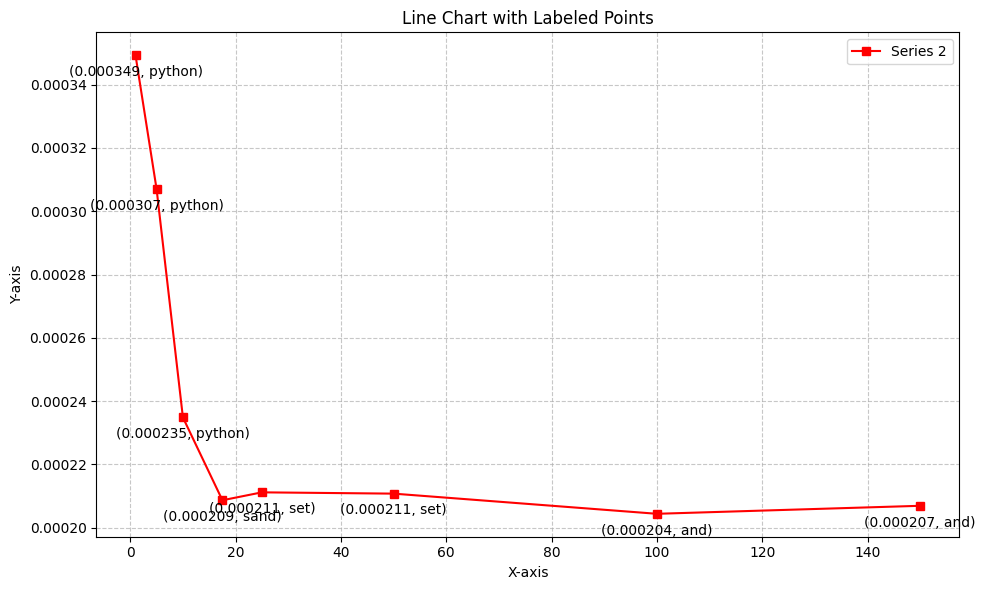

In [407]:
import matplotlib.pyplot as plt
import numpy as np

# Sample data
x = [tup[0] for tup in sorted(feat_num_concept_arr)]
y1 = [tup[1] for tup in sorted(feat_num_concept_arr)]
y2 = [tup[1] for tup in sorted(feat_num_prob_arr)]
# y3 = [tup[1] for tup in sorted(feat_num_ratio_arr)]

# Create the plot
plt.figure(figsize=(10, 6))

# Plot each line with different colors and markers
# plt.plot(x, y1, 'bo-', label='Series 1')  # Blue line with circles
plt.plot(np.array(x), y2, 'rs-', label='Series 2')  # Red line with squares
# plt.plot(x, y3, 'gd-', label='Series 3')  # Green line with diamonds

# Label each point for all three series
for i in range(len(x)):
#     # Labels for series 1
#     plt.annotate(f'({x[i]}, {y1[i]})', 
#                 (x[i], y1[i]), 
#                 textcoords="offset points", 
#                 xytext=(0,10),
#                 ha='center')
    
    # Labels for series 2
    plt.annotate(f'({y2[i]:01f}, {y1[i]})', 
                (x[i], y2[i]), 
                textcoords="offset points", 
                xytext=(0,-15),
                ha='center')
    
#     # Labels for series 3
#     plt.annotate(f'({x[i]}, {y3[i]})', 
#                 (x[i], y3[i]), 
#                 textcoords="offset points", 
#                 xytext=(0,10),
#                 ha='center')

# Customize the plot
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.title('Line Chart with Labeled Points')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)

# Adjust layout to prevent label overlap
plt.tight_layout()

# Show the plot
plt.show()

## Stop

### Covariance Analysis

In [ ]:
# subtract from default, label, and print trends
text_probs_altered.shape

# selected_vocab = all_imagenet_class_names
selected_vocab = larger_vocab

cov_stuff_avgs = []

# switch to datacomp eval??
# we run this for each feature over all of imagenet eval and create average absolute/ratio
# difference vectors
per_feat_avg_vectors = []
for j, text_probs_altered in enumerate(text_probs_altered_list):
    print(f"\n\nFor Feature {random_feat_idxs[j]}")
    print(f"\n\nFor Feature {random_feat_idxs[j]}")
    logit_diff = text_probs_altered - text_probs_default
    logit_ratio = text_probs_altered/text_probs_default
    
    vals, idxs = torch.topk(logit_diff,k=5)
    vals_least, idxs_least = torch.topk(logit_diff,k=5,largest=False)
    
    ratios, ratios_idxs = torch.topk(logit_ratio,k=5)
    ratios_least, ratios_idxs_least = torch.topk(logit_ratio,k=5,largest=False)
    
    feat_avg_vectors = []
    for i in range(logit_diff.shape[0]):
#         print(f"\nImage {i} ========================\nMost Changed, by Absolute Diff\n:{vals[i]}")
#         print(np.array(all_imagenet_class_names)[idxs.cpu()][i])
#         print(vals_least[i])
#         print(np.array(all_imagenet_class_names)[idxs_least.cpu()][i])
        
        print("\nMost Changed, by Ratio:")
        print(ratios[i])
        print(np.array(selected_vocab)[ratios_idxs.cpu()][i])
#         print(ratios_least[i])
#         print(np.array(selected_vocab)[ratios_idxs_least.cpu()][i])
        
        text = tokenizer(np.array(selected_vocab)[ratios_idxs.cpu()][i])
#         text_least = tokenizer(np.array(selected_vocab)[ratios_idxs_least.cpu()][i])
        text_features = og_model.encode_text(text.cuda())
        cov_over_images.append(text_features)
#         text_features_least = og_model.encode_text(text_least.cuda())
        print(torch.tril(torch.cov(text_features), diagonal=-1))
        print(torch.tril(torch.cov(text_features), diagonal=-1).sum()/10)
#         cov_stuff = torch.tril(torch.cov(text_features), diagonal=-1).sum()/10
#         cov_stuff_least = torch.tril(torch.cov(text_features_least), diagonal=-1).sum()/10
    print(torch.tril(torch.cov(torch.cat(cov_over_images)), diagonal=-1).shape)
    n = torch.tril(torch.cov(torch.cat(cov_over_images)), diagonal=-1).shape[0]
    num_elements = (n**2)/2 - n
    cov_stuff = torch.tril(torch.cov(torch.cat(cov_over_images)), diagonal=-1).sum()/num_elements
    cov_stuff_avgs.append(cov_stuff)
#         cov_stuff_avgs_least.append(cov_stuff_least)
    if j > 10:
        break
print(torch.tensor(cov_stuff_avgs).mean())
# print(torch.tensor(cov_stuff_avgs_least).mean())

In [ ]:
top_k_imgnet_labels = 10

In [ ]:
from matplotlib import pyplot as plt
from collections import defaultdict, Counter

feat_autolabels_default = defaultdict(Counter)
for i in range(text_probs_default.shape[0]):
    vals, idxs = torch.topk(text_probs_default[i],k=top_k_imgnet_labels)
    print(i)
    for k, idx in enumerate(idxs):
        feat_autolabels_default[i][all_imagenet_class_names[idx]] += vals[k]
        print("\t", all_imagenet_class_names[idx])
feat_autolabels_default

In [ ]:
# subtract from default, label, and print trends
text_probs_altered.shape

for text_probs_altered in text_probs_altered_list:
    logit_diff = text_probs_altered - text_probs_default
    print(logit_diff)
    vals, idxs = torch.topk(logit_diff,k=5)
    print(vals, np.array(all_imagenet_class_names[idxs])
    break

In [ ]:
all_imagenet_class_names

In [ ]:
from collections import defaultdict, Counter

feat_autolabels_altered_list = []
for text_probs_altered in text_probs_altered_list:
    feat_autolabels_altered = defaultdict(Counter)
    for i in range(text_probs_altered.shape[0]):
        vals, idxs = torch.topk(text_probs_altered[i],k=top_k_imgnet_labels)
#         print(i)
        for k, idx in enumerate(idxs):
            feat_autolabels_altered[i][all_imagenet_class_names[idx]] += vals[k]
#             print("\t", all_imagenet_class_names[idx])
    feat_autolabels_altered_list.append(feat_autolabels_altered)

start_idx = 9
end_idx = 10
    
h = 0
for key in feat_autolabels_default:
    print(f"\nfeat_autolabels_default img {key}:\n {feat_autolabels_default[key]}\n")
    h += 1
    if h > end_idx:
        break
for i, f_a_a in enumerate(feat_autolabels_altered_list):
    print("============= feature number ", i, "====================")
    h = 0
    for key in range(start_idx, end_idx):
#         print("\n", key)
#         for item in f_a_a[key]:
#             print("\t", item, f_a_a[key][item].cpu().item())
        print(f"\nf_a_a img {key}:\n {f_a_a[key]}\n")


In [ ]:
for i in range(text_probs_default.shape[0]):
    vals, idxs = torch.topk(text_probs_default[i],k=1000)
    print(i, ind_to_name[str(idxs[0].cpu().item())][1])
    fig, ax = plt.subplots(figsize=(10, 10))
#     ax.xaxis.set_ticks((1000))
#     ax.set_xticks(list(range(1000)), [ind_to_name[str(idxs[idx].cpu().item())][1] for idx in idxs])
    plt.bar(idxs.cpu(), vals.cpu(), width=5)
    break

In [ ]:
plt.imshow(batch_images[2].cpu().permute((1,2,0)).numpy())

In [ ]:

@torch.no_grad()
def get_heatmap(
          image,
          model,
          sparse_autoencoder,
          feature_id,
): 
    image = image.to(cfg.device)
    _, cache = model.run_with_cache(image.unsqueeze(0))

    post_reshaped = einops.rearrange(cache[sparse_autoencoder.cfg.hook_point], "batch seq d_mlp -> (batch seq) d_mlp")
    # Compute activations (not from a fwd pass, but explicitly, by taking only the feature we want)
    # This code is copied from the first part of the 'forward' method of the AutoEncoder class
    sae_in =  post_reshaped - sparse_autoencoder.b_dec # Remove decoder bias as per Anthropic
    print(f"sae_in.shape: {sae_in.shape}")
    acts = einops.einsum(
            sae_in,
            sparse_autoencoder.W_enc[:, feature_id],
            "x d_in, d_in -> x",
        )
    return acts 
     
def image_patch_heatmap(activation_values,image_size=224, pixel_num=14):
    activation_values = activation_values.detach().cpu().numpy()
    activation_values = activation_values[1:]
    activation_values = activation_values.reshape(pixel_num, pixel_num)

    # Create a heatmap overlay
    heatmap = np.zeros((image_size, image_size))
    patch_size = image_size // pixel_num

    for i in range(pixel_num):
        for j in range(pixel_num):
            heatmap[i*patch_size:(i+1)*patch_size, j*patch_size:(j+1)*patch_size] = activation_values[i, j]

    return heatmap


In [ ]:
from matplotlib import pyplot as plt

grid_size = 1
fig, axs = plt.subplots(int(np.ceil(len(images)/grid_size)), grid_size, figsize=(15, 15))
name=  f"Category: uhh,  Feature: {0}"
fig.suptitle(name)#, y=0.95)
for ax in axs.flatten():
    ax.axis('off')
complete_bid = []

heatmap = get_heatmap(batch_images[2], model,sparse_autoencoder, 10000)
heatmap = image_patch_heatmap(heatmap, pixel_num=224//cfg.patch_size)

display = batch_images[2].cpu().numpy().transpose(1, 2, 0)

has_zero = False

In [ ]:
plt.imshow(display)
plt.imshow(heatmap, alpha=0.3)

In [ ]:
plt.imshow(display)
plt.imshow(heatmap, alpha=0.3)